# Import

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

# LU-разложение

In [2]:
def lu_decomposition(A, b):
    """LU-разложение с решением системы A*x = b"""
    n = A.shape[0]
    eps = 1e-12
    
    # Инициализация матриц
    L = np.eye(n, dtype=np.float64)  # Единичная матрица
    U = A.copy().astype(np.float64)
    b = b.copy().astype(np.float64)
    
    # Массив для отслеживания перестановок строк
    P = np.arange(n)
    
    # LU-разложение с частичным выбором ведущего элемента
    for i in range(n):
        # Выбор ведущего элемента в столбце i
        max_row = i + np.argmax(np.abs(U[i:, i]))
        
        if np.abs(U[max_row, i]) < eps:
            raise ValueError("Матрица вырождена или плохо обусловлена")
        
        # Перестановка строк, если необходимо
        if max_row != i:
            # Меняем строки в U
            U[[i, max_row]] = U[[max_row, i]]
            # Меняем строки в L для уже вычисленных элементов
            if i > 0:
                L[[i, max_row], :i] = L[[max_row, i], :i]
            # Меняем строки в b
            b[[i, max_row]] = b[[max_row, i]]
            # Обновляем массив перестановок
            P[i], P[max_row] = P[max_row], P[i]
        
        # Вычисление множителей и обновление матриц
        for j in range(i+1, n):
            mult = U[j, i] / U[i, i]
            L[j, i] = mult
            U[j, i:] -= mult * U[i, i:]
            U[j, i] = 0.0  # Для чистоты
    
    # Решение системы L*y = b (прямой ход)
    y = np.zeros(n)
    for i in range(n):
        y[i] = b[i] - np.dot(L[i, :i], y[:i])
    
    # Решение системы U*x = y (обратный ход)
    x = np.zeros(n)
    for i in range(n-1, -1, -1):
        x[i] = (y[i] - np.dot(U[i, i+1:], x[i+1:])) / U[i, i]
    
    return x

# Метод Гаусса

In [3]:
def gauss_column_pivot(A, b, eps=1e-12):
    """Метод Гаусса с выбором ведущего элемента по столбцу"""
    A = A.astype(float).copy()
    b = b.astype(float).copy()
    n = len(b)
    
    # Прямой ход
    for k in range(n):
        # Выбор максимального элемента по столбцу
        max_row = np.argmax(np.abs(A[k:, k])) + k
        
        if abs(A[max_row, k]) < eps:
            raise ValueError("Матрица вырождена или плохо обусловлена")
        
        # Перестановка строк
        if max_row != k:
            A[[k, max_row]] = A[[max_row, k]]
            b[[k, max_row]] = b[[max_row, k]]
        
        # Исключение
        for i in range(k+1, n):
            factor = A[i, k] / A[k, k]
            A[i, k:] -= factor * A[k, k:]
            b[i] -= factor * b[k]
            A[i, k] = 0.0
    
    # Обратный ход
    x = np.zeros(n)
    
    for i in range(n-1, -1, -1):
        s = np.dot(A[i, i+1:], x[i+1:])
        x[i] = (b[i] - s) / A[i, i]
    
    return x

# Генерация матриц

In [4]:
def generate_matrix(n, matrix_type='random', condition_number=None):
    """
    Генерация тестовых матриц разных типов
    
    Параметры:
    n - размер матрицы
    matrix_type - тип матрицы:
        'random' - случайная
        'hilbert' - матрица Гильберта (плохо обусловленная)
        'diag_dominant' - с диагональным преобладанием
        'spd' - симметричная положительно определенная
    condition_number - желаемое число обусловленности
    """
    if matrix_type == 'random':
        A = np.random.randn(n, n)
        # Добавляем диагональную составляющую для лучшей обусловленности
        A += n * np.eye(n)
        
    elif matrix_type == 'hilbert':
        # Матрица Гильберта (очень плохо обусловленная)
        A = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                A[i, j] = 1.0 / (i + j + 1)
                
    elif matrix_type == 'diag_dominant':
        # Матрица со строгим диагональным преобладанием
        A = np.random.randn(n, n) * 0.1
        np.fill_diagonal(A, np.abs(A).sum(axis=1) + np.random.rand(n) + 1)
        
    elif matrix_type == 'spd':
        # Симметричная положительно определенная матрица
        A = np.random.randn(n, n)
        A = A @ A.T  # Делаем симметричной
        A += n * np.eye(n)  # Делаем положительно определенной
        
    else:
        raise ValueError(f"Неизвестный тип матрицы: {matrix_type}")
    
    # Если задано число обусловленности, масштабируем собственные значения
    if condition_number is not None and matrix_type != 'hilbert':
        U, S, Vt = np.linalg.svd(A)
        min_sv = 1.0
        max_sv = condition_number
        S_scaled = np.linspace(min_sv, max_sv, n)
        A = U @ np.diag(S_scaled) @ Vt
    
    return A

# Сравнение методов

In [5]:
def compare_direct_methods():
    """Сравнение трех прямых методов решения СЛАУ"""
    sizes = [10, 50, 100, 200, 500]  # Размеры матриц
    matrix_types = ['random', 'diag_dominant', 'spd']  # Типы матриц
    results = []
    
    for n in sizes:
        for matrix_type in matrix_types:
            print(f"\n{'='*60}")
            print(f"Размер матрицы: {n}x{n}, Тип: {matrix_type}")
            print(f"{'='*60}")
            
            # Генерируем матрицу и вектор
            A = generate_matrix(n, matrix_type)
            b = np.random.randn(n)
            
            # Вычисляем эталонное решение
            try:
                start = time.time()
                x_ref = np.linalg.solve(A, b)
                time_ref = time.time() - start
                residual_ref = np.linalg.norm(A @ x_ref - b)
            except np.linalg.LinAlgError as e:
                print(f"  Ошибка в numpy.linalg.solve: {e}")
                continue
            
            # Тестируем методы
            methods = []
            
            # 1. LU-разложение
            try:
                start = time.time()
                x_lu = lu_decomposition(A, b)
                time_lu = time.time() - start
                residual_lu = np.linalg.norm(A @ x_lu - b)
                error_lu = np.linalg.norm(x_lu - x_ref)
                methods.append(('LU', time_lu, residual_lu, error_lu))
            except Exception as e:
                print(f"  Ошибка в LU-разложении: {e}")
                methods.append(('LU', np.nan, np.nan, np.nan))
            
            # 2. Метод Гаусса (самописный)
            try:
                start = time.time()
                x_gauss = gauss_column_pivot(A, b)
                time_gauss = time.time() - start
                residual_gauss = np.linalg.norm(A @ x_gauss - b)
                error_gauss = np.linalg.norm(x_gauss - x_ref)
                methods.append(('Gauss', time_gauss, residual_gauss, error_gauss))
            except Exception as e:
                print(f"  Ошибка в методе Гаусса: {e}")
                methods.append(('Gauss', np.nan, np.nan, np.nan))
            
            # 3. numpy.linalg.solve
            methods.append(('numpy.solve', time_ref, residual_ref, 0.0))
            
            # Сохраняем результаты
            for method_name, method_time, method_residual, method_error in methods:
                if not np.isnan(method_time):
                    results.append({
                        'n': n,
                        'matrix_type': matrix_type,
                        'method': method_name,
                        'time': method_time,
                        'residual': method_residual,
                        'error': method_error,
                        'cond': np.linalg.cond(A)
                    })
            
            # Выводим текущие результаты
            print(f"Число обусловленности: {np.linalg.cond(A):.2e}")
            print(f"{'Метод':<15} {'Время (сек)':<15} {'Невязка':<15} {'Ошибка':<15}")
            print("-" * 60)
            
            for method_name, method_time, method_residual, method_error in methods:
                if np.isnan(method_time):
                    print(f"{method_name:<15} {'ОШИБКА':<15} {'-':<15} {'-':<15}")
                else:
                    print(f"{method_name:<15} {method_time:<15.6f} {method_residual:<15.2e} {method_error:<15.2e}")
    
    return results

# Визуализация

In [6]:
def plot_direct_methods_comparison(results):
    """Визуализация сравнения прямых методов"""
    # Группируем результаты по типу матрицы
    matrix_types = set(r['matrix_type'] for r in results)
    
    for matrix_type in matrix_types:
        type_results = [r for r in results if r['matrix_type'] == matrix_type]
        
        # Создаем словарь для группировки по методу
        methods_data = {}
        for r in type_results:
            method = r['method']
            if method not in methods_data:
                methods_data[method] = {'sizes': [], 'times': [], 'residuals': [], 'errors': []}
            
            methods_data[method]['sizes'].append(r['n'])
            methods_data[method]['times'].append(r['time'])
            methods_data[method]['residuals'].append(r['residual'])
            methods_data[method]['errors'].append(r['error'])
        
        # Создаем графики
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'Сравнение прямых методов для матриц типа: {matrix_type}', fontsize=16, fontweight='bold')
        
        colors = {'LU': 'blue', 'Gauss': 'red', 'numpy.solve': 'green'}
        markers = {'LU': 'o', 'Gauss': 's', 'numpy.solve': '^'}
        
        # 1. Время выполнения
        ax = axes[0, 0]
        for method, data in methods_data.items():
            if method in colors:
                ax.plot(data['sizes'], data['times'], 
                       color=colors[method], marker=markers[method], 
                       label=method, linewidth=2, markersize=8)
        ax.set_xlabel('Размер матрицы', fontsize=12)
        ax.set_ylabel('Время выполнения (сек)', fontsize=12)
        ax.set_title('Время выполнения', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xscale('log')
        ax.set_yscale('log')
        
        # 2. Точность (норма невязки)
        ax = axes[0, 1]
        for method, data in methods_data.items():
            if method in colors:
                ax.semilogy(data['sizes'], data['residuals'], 
                          color=colors[method], marker=markers[method], 
                          label=method, linewidth=2, markersize=8)
        ax.set_xlabel('Размер матрицы', fontsize=12)
        ax.set_ylabel('Норма невязки (log)', fontsize=12)
        ax.set_title('Точность решения', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xscale('log')
        
        # 3. Ошибка относительно numpy.solve
        ax = axes[1, 0]
        for method, data in methods_data.items():
            if method != 'numpy.solve' and method in colors:
                ax.semilogy(data['sizes'], data['errors'], 
                          color=colors[method], marker=markers[method], 
                          label=method, linewidth=2, markersize=8)
        ax.set_xlabel('Размер матрицы', fontsize=12)
        ax.set_ylabel('Ошибка относительно numpy.solve (log)', fontsize=12)
        ax.set_title('Сравнение с эталонным решением', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xscale('log')
        
        # 4. Относительная скорость (по сравнению с numpy.solve)
        ax = axes[1, 1]
        if 'numpy.solve' in methods_data and methods_data['numpy.solve']['times']:
            numpy_times = methods_data['numpy.solve']['times']
            for method, data in methods_data.items():
                if method != 'numpy.solve' and method in colors and len(data['times']) == len(numpy_times):
                    speed_ratio = [t_numpy/t_method if t_method > 0 else np.nan 
                                 for t_numpy, t_method in zip(numpy_times, data['times'])]
                    ax.plot(data['sizes'], speed_ratio, 
                           color=colors[method], marker=markers[method], 
                           label=f'{method}/numpy', linewidth=2, markersize=8)
            ax.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Равная скорость')
            ax.set_xlabel('Размер матрицы', fontsize=12)
            ax.set_ylabel('Отношение времени (numpy/метод)', fontsize=12)
            ax.set_title('Относительная скорость', fontsize=14, fontweight='bold')
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.set_xscale('log')
        
        plt.tight_layout()
        plt.savefig(f'direct_methods_comparison_{matrix_type}.png', dpi=150, bbox_inches='tight')
        plt.show()

# Тестирование

In [7]:
def test_specific_examples():
    """Тестирование на конкретных примерах"""
    print("="*70)
    print("ТЕСТИРОВАНИЕ НА КОНКРЕТНЫХ ПРИМЕРАХ")
    print("="*70)
    
    # Пример 1: Простая матрица 3x3
    print("\nПример 1: Простая матрица 3x3")
    A1 = np.array([[2, 1, -1],
                   [-3, -1, 2],
                   [-2, 1, 2]], dtype=float)
    b1 = np.array([8, -11, -3], dtype=float)
    
    print(f"Матрица A:\n{A1}")
    print(f"Вектор b: {b1}")
    
    # Решения разными методами
    try:
        x_ref = np.linalg.solve(A1, b1)
        print(f"\nЭталонное решение (numpy.linalg.solve): {x_ref}")
        
        x_lu = lu_decomposition(A1, b1)
        print(f"LU-разложение: {x_lu}")
        print(f"  Невязка: {np.linalg.norm(A1 @ x_lu - b1):.2e}")
        print(f"  Ошибка отн. эталона: {np.linalg.norm(x_lu - x_ref):.2e}")
        
        x_gauss = gauss_column_pivot(A1, b1)
        print(f"Метод Гаусса: {x_gauss}")
        print(f"  Невязка: {np.linalg.norm(A1 @ x_gauss - b1):.2e}")
        print(f"  Ошибка отн. эталона: {np.linalg.norm(x_gauss - x_ref):.2e}")
    except Exception as e:
        print(f"Ошибка: {e}")
    
    # Пример 2: Матрица Гильберта (плохо обусловленная)
    print("\n" + "-"*70)
    print("Пример 2: Матрица Гильберта 4x4 (плохо обусловленная)")
    n = 4
    A2 = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            A2[i, j] = 1.0 / (i + j + 1)
    b2 = np.ones(n)
    
    print(f"Матрица Гильберта 4x4 (обусловленность: {np.linalg.cond(A2):.2e})")
    
    try:
        x_ref2 = np.linalg.solve(A2, b2)
        print(f"\nЭталонное решение: {x_ref2}")
        
        x_lu2 = lu_decomposition(A2, b2)
        print(f"LU-разложение: {x_lu2}")
        print(f"  Невязка: {np.linalg.norm(A2 @ x_lu2 - b2):.2e}")
        print(f"  Ошибка отн. эталона: {np.linalg.norm(x_lu2 - x_ref2):.2e}")
        
        x_gauss2 = gauss_column_pivot(A2, b2)
        print(f"Метод Гаусса: {x_gauss2}")
        print(f"  Невязка: {np.linalg.norm(A2 @ x_gauss2 - b2):.2e}")
        print(f"  Ошибка отн. эталона: {np.linalg.norm(x_gauss2 - x_ref2):.2e}")
    except Exception as e:
        print(f"Ошибка: {e}")
    
    # Пример 3: Матрица с диагональным преобладанием
    print("\n" + "-"*70)
    print("Пример 3: Матрица с диагональным преобладанием 5x5")
    A3 = np.array([[10, 2, 1, 1, 1],
                   [1, 12, 3, 2, 1],
                   [2, 1, 15, 3, 2],
                   [1, 2, 1, 18, 4],
                   [1, 1, 2, 1, 20]], dtype=float)
    b3 = np.array([15, 19, 23, 26, 25], dtype=float)
    
    print(f"Матрица с диаг. преобладанием (обусловленность: {np.linalg.cond(A3):.2e})")
    
    try:
        x_ref3 = np.linalg.solve(A3, b3)
        print(f"\nЭталонное решение: {x_ref3}")
        
        x_lu3 = lu_decomposition(A3, b3)
        print(f"LU-разложение: {x_lu3}")
        print(f"  Невязка: {np.linalg.norm(A3 @ x_lu3 - b3):.2e}")
        print(f"  Ошибка отн. эталона: {np.linalg.norm(x_lu3 - x_ref3):.2e}")
        
        x_gauss3 = gauss_column_pivot(A3, b3)
        print(f"Метод Гаусса: {x_gauss3}")
        print(f"  Невязка: {np.linalg.norm(A3 @ x_gauss3 - b3):.2e}")
        print(f"  Ошибка отн. эталона: {np.linalg.norm(x_gauss3 - x_ref3):.2e}")
    except Exception as e:
        print(f"Ошибка: {e}")

# Анализ устойчивости

In [8]:
def analyze_numerical_stability():
    """Анализ численной устойчивости методов"""
    print("\n" + "="*70)
    print("АНАЛИЗ ЧИСЛЕННОЙ УСТОЙЧИВОСТИ")
    print("="*70)
    
    # Тест на плохо обусловленных матрицах
    sizes = [5, 10, 15]
    condition_numbers = [1e3, 1e6, 1e9]
    
    print("\nТест на матрицах с разной обусловленностью:")
    print(f"{'Размер':<10} {'Обусл.':<15} {'Метод':<15} {'Невязка':<20} {'Ошибка':<20}")
    print("-" * 80)
    
    for n in sizes:
        for cond_num in condition_numbers:
            # Генерируем матрицу с заданным числом обусловленности
            A = generate_matrix(n, 'random', cond_num)
            b = np.ones(n)
            
            try:
                # Эталонное решение
                x_ref = np.linalg.solve(A, b)
                
                # Тестируем методы
                methods = [
                    ('LU', lu_decomposition(A, b)),
                    ('Gauss', gauss_column_pivot(A, b))
                ]
                
                for method_name, x in methods:
                    residual = np.linalg.norm(A @ x - b)
                    error = np.linalg.norm(x - x_ref)
                    print(f"{n:<10} {cond_num:<15.0e} {method_name:<15} {residual:<20.2e} {error:<20.2e}")
                    
            except Exception as e:
                print(f"{n:<10} {cond_num:<15.0e} {'ВСЕ':<15} {'ОШИБКА':<20} {str(e)[:20]:<20}")

СРАВНЕНИЕ ПРЯМЫХ МЕТОДОВ РЕШЕНИЯ СЛАУ
Сравниваемые методы:
  1. LU-разложение (самописное)
  2. Метод Гаусса с выбором ведущего элемента по столбцу (самописный)
  3. numpy.linalg.solve (библиотечный метод)
ТЕСТИРОВАНИЕ НА КОНКРЕТНЫХ ПРИМЕРАХ

Пример 1: Простая матрица 3x3
Матрица A:
[[ 2.  1. -1.]
 [-3. -1.  2.]
 [-2.  1.  2.]]
Вектор b: [  8. -11.  -3.]

Эталонное решение (numpy.linalg.solve): [ 2.  3. -1.]
LU-разложение: [ 2.  3. -1.]
  Невязка: 1.83e-15
  Ошибка отн. эталона: 2.71e-15
Метод Гаусса: [ 2.  3. -1.]
  Невязка: 8.88e-16
  Ошибка отн. эталона: 1.26e-15

----------------------------------------------------------------------
Пример 2: Матрица Гильберта 4x4 (плохо обусловленная)
Матрица Гильберта 4x4 (обусловленность: 1.55e+04)

Эталонное решение: [  -4.   60. -180.  140.]
LU-разложение: [  -4.   60. -180.  140.]
  Невязка: 3.24e-15
  Ошибка отн. эталона: 5.29e-12
Метод Гаусса: [  -4.   60. -180.  140.]
  Невязка: 2.23e-15
  Ошибка отн. эталона: 5.39e-12

-------------------

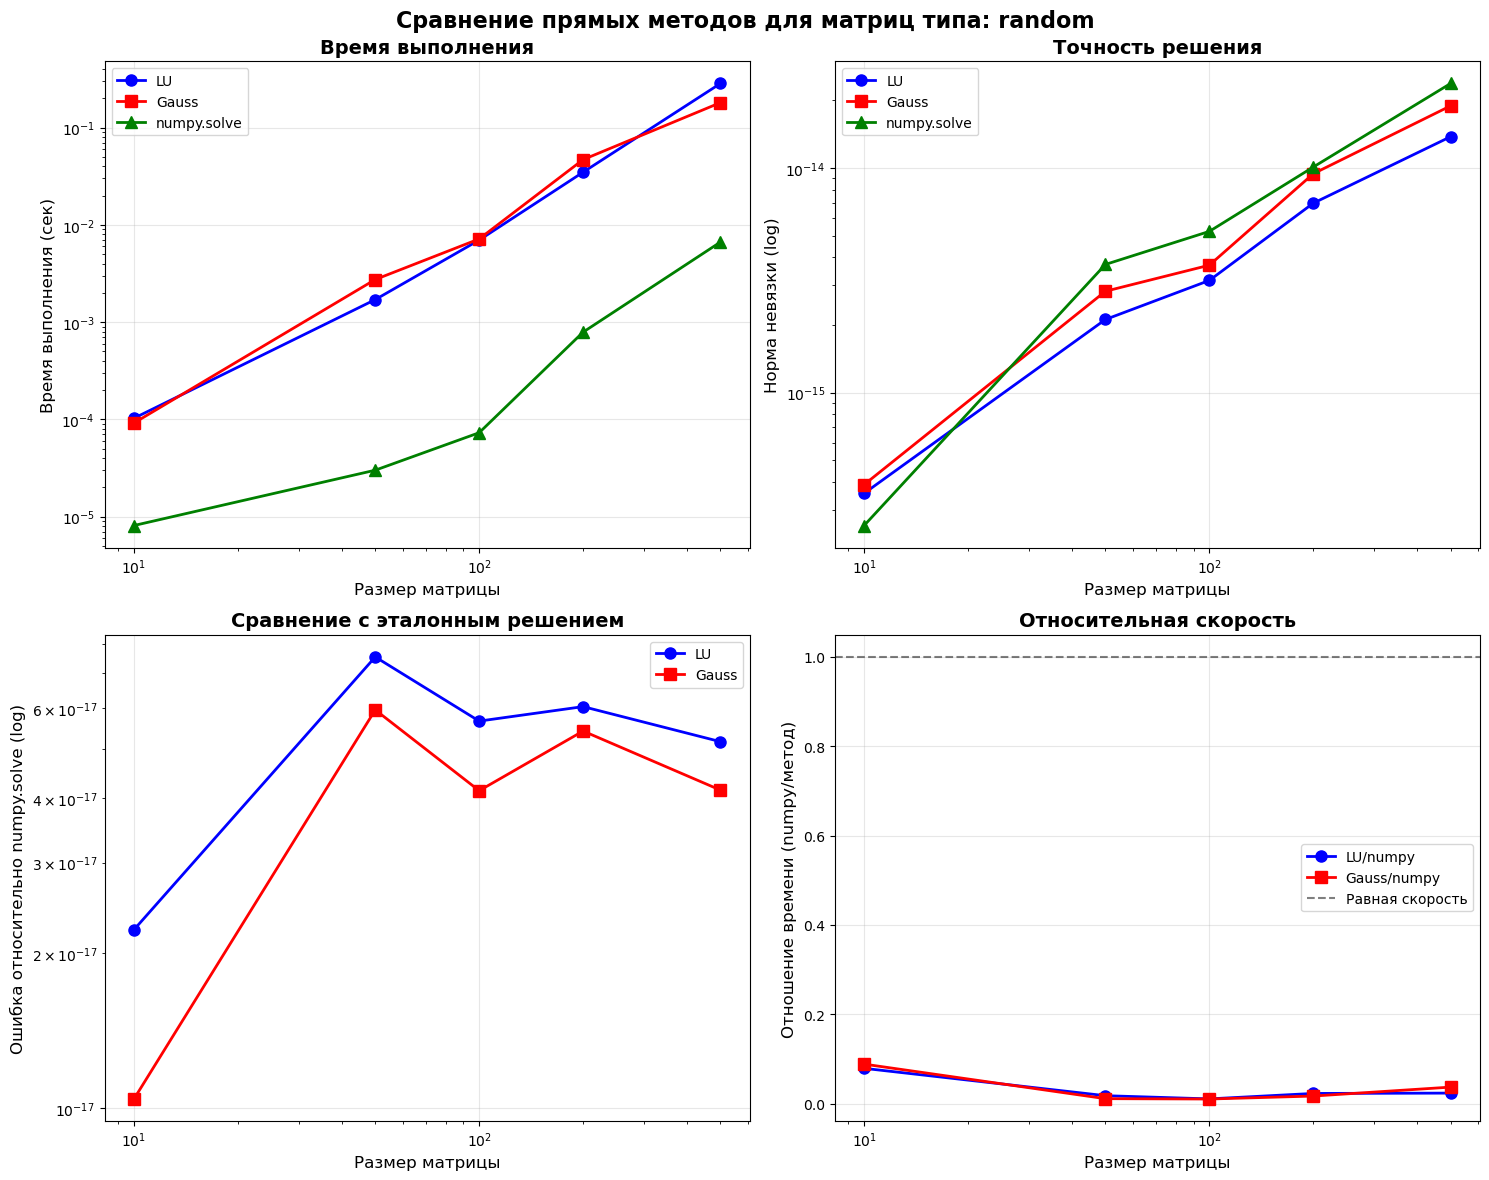

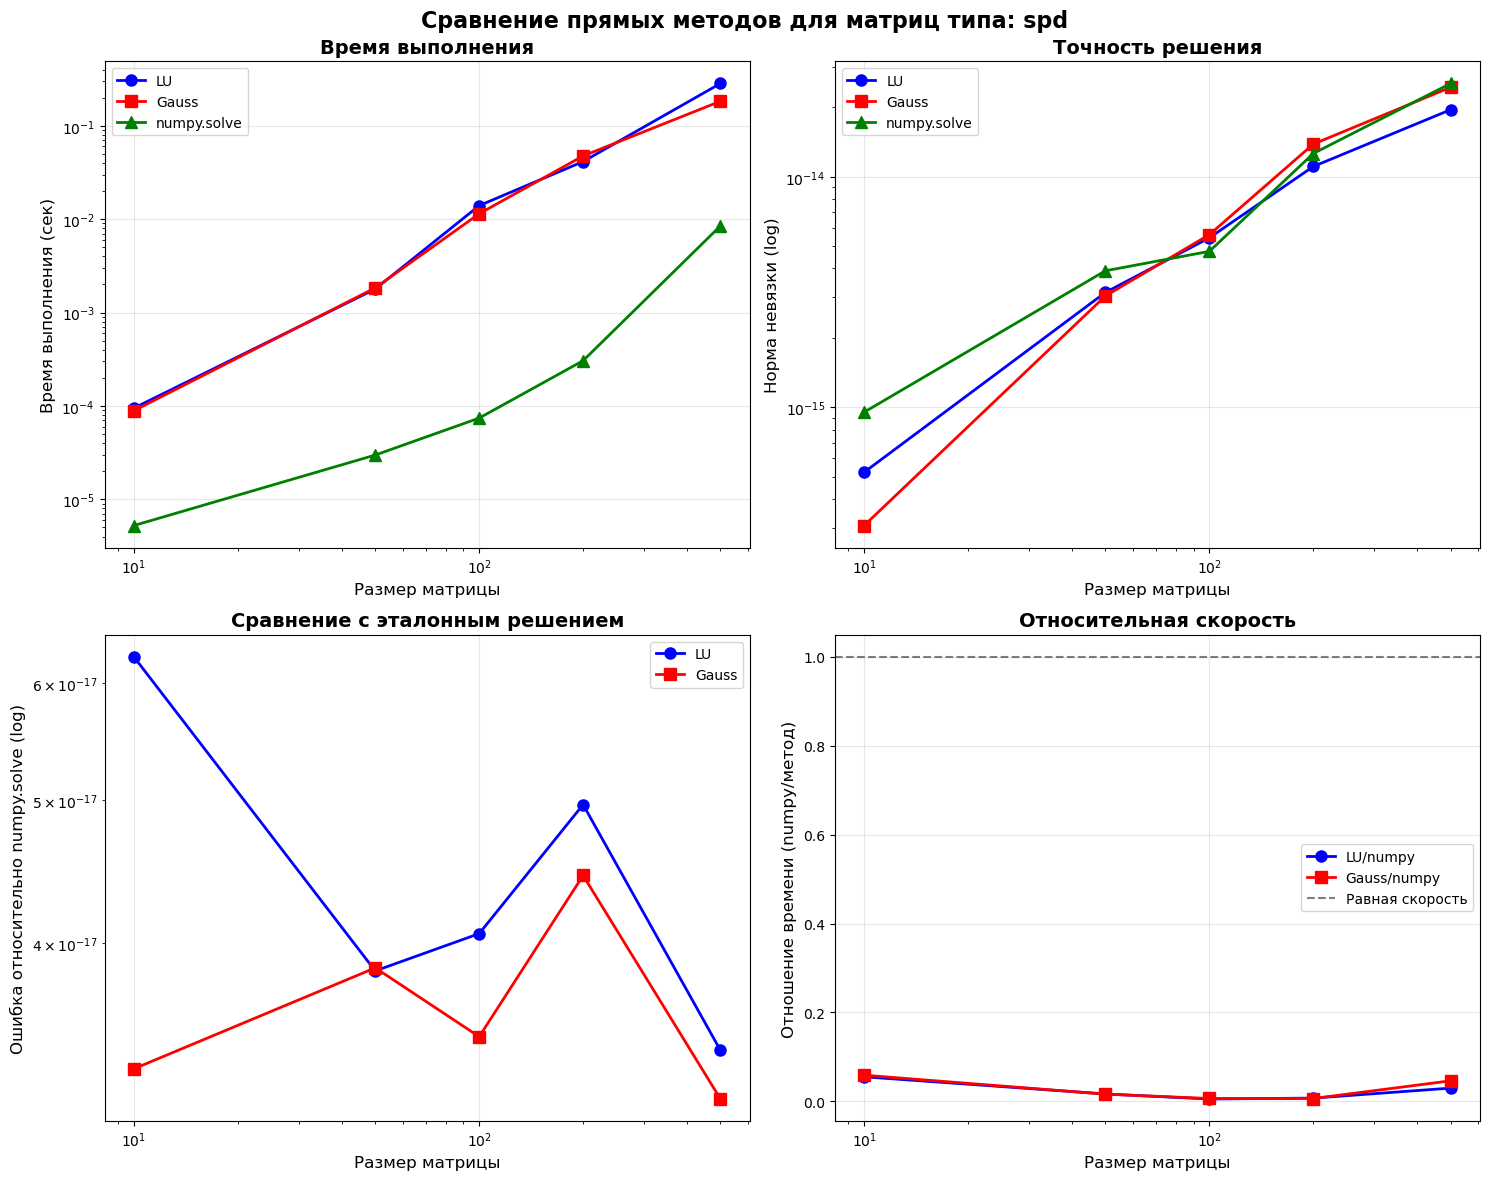

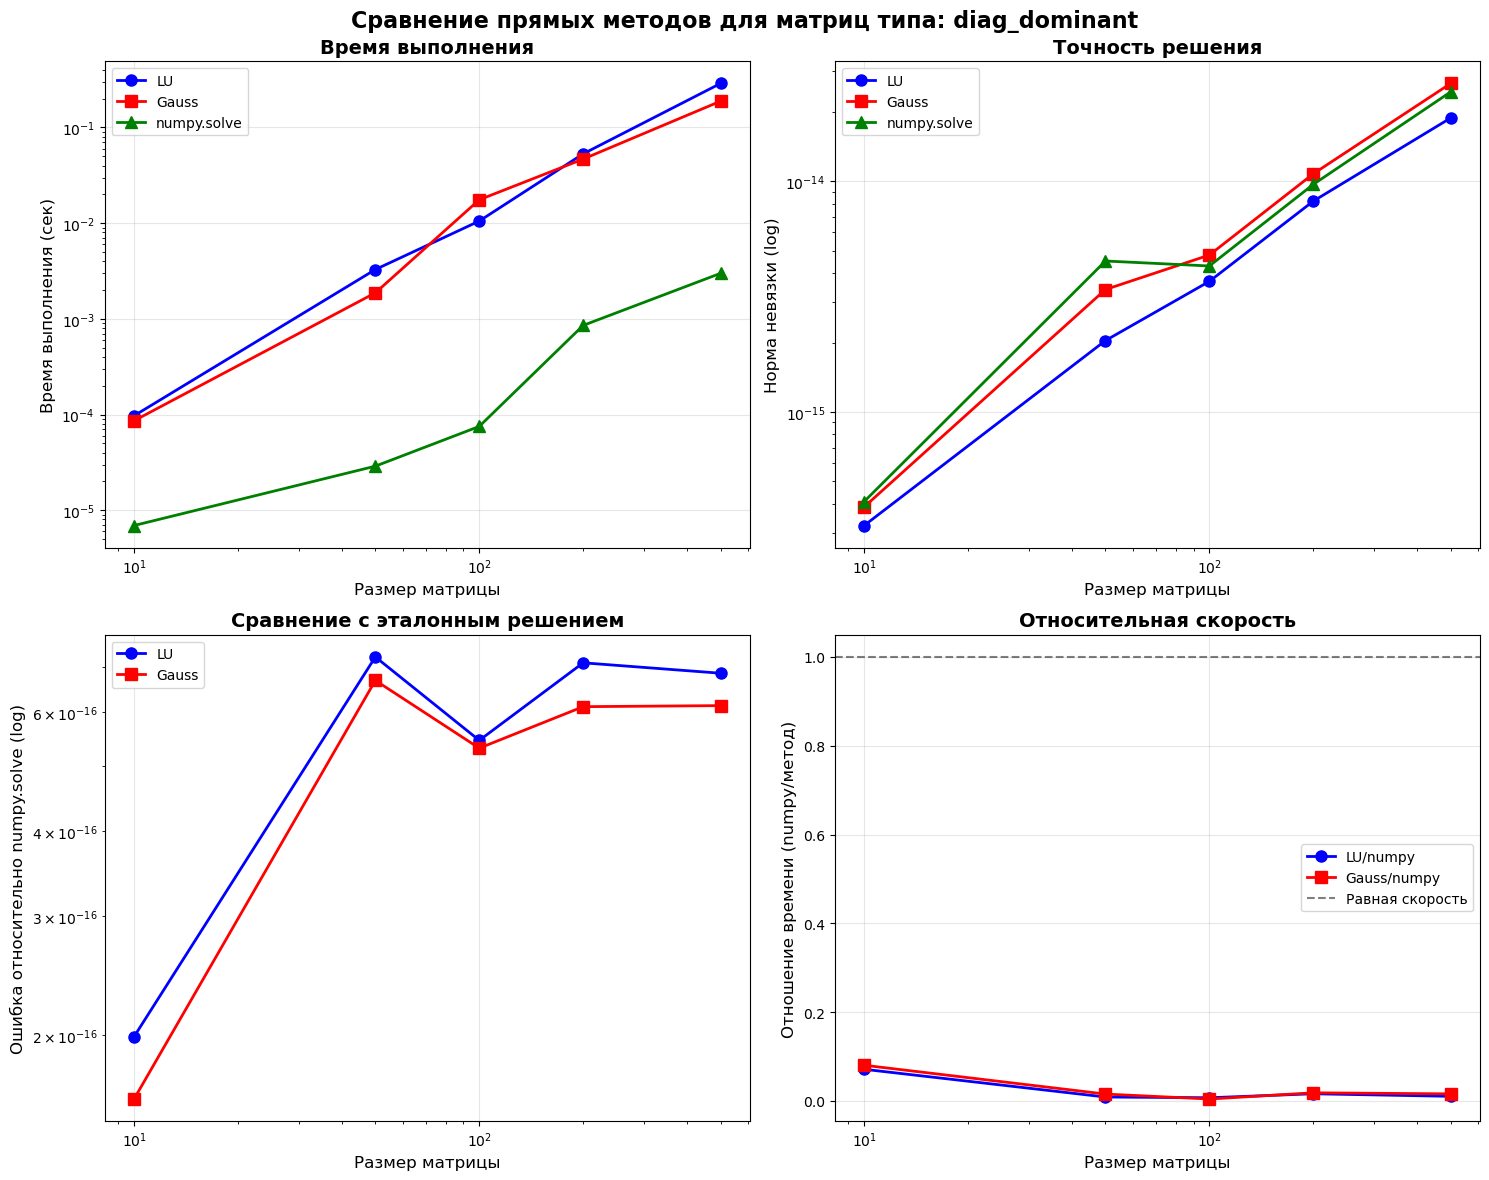


ИТОГОВАЯ СВОДНАЯ ТАБЛИЦА

Тип матрицы: random
--------------------------------------------------------------------------------
Размер     Метод           Время (сек)     Невязка              Ошибка               Обусл.         
--------------------------------------------------------------------------------
10         Gauss           0.000092        3.90e-16             1.04e-17             1.91e+00       
10         LU              0.000103        3.57e-16             2.22e-17             1.91e+00       
10         numpy.solve     0.000008        2.56e-16             0.00e+00             1.91e+00       
50         Gauss           0.002743        2.83e-15             5.95e-17             1.47e+00       
50         LU              0.001705        2.12e-15             7.54e-17             1.47e+00       
50         numpy.solve     0.000030        3.72e-15             0.00e+00             1.47e+00       
100        Gauss           0.007170        3.69e-15             4.14e-17            

In [9]:
print("СРАВНЕНИЕ ПРЯМЫХ МЕТОДОВ РЕШЕНИЯ СЛАУ")
print("="*70)
print("Сравниваемые методы:")
print("  1. LU-разложение (самописное)")
print("  2. Метод Гаусса с выбором ведущего элемента по столбцу (самописный)")
print("  3. numpy.linalg.solve (библиотечный метод)")
print("="*70)

# Тестирование на конкретных примерах
test_specific_examples()

# Анализ численной устойчивости
analyze_numerical_stability()

# Основное сравнение
print("\n" + "="*70)
print("ОСНОВНОЕ СРАВНЕНИЕ НА РАЗНЫХ РАЗМЕРАХ И ТИПАХ МАТРИЦ")
print("="*70)

try:
    results = compare_direct_methods()
    
    if results:
        # Визуализация результатов
        plot_direct_methods_comparison(results)
        
        # Вывод итоговой таблицы
        print("\n" + "="*70)
        print("ИТОГОВАЯ СВОДНАЯ ТАБЛИЦА")
        print("="*70)
        
        # Группируем по типу матрицы
        matrix_types = set(r['matrix_type'] for r in results)
        
        for matrix_type in matrix_types:
            print(f"\nТип матрицы: {matrix_type}")
            print("-"*80)
            print(f"{'Размер':<10} {'Метод':<15} {'Время (сек)':<15} {'Невязка':<20} {'Ошибка':<20} {'Обусл.':<15}")
            print("-"*80)
            
            type_results = [r for r in results if r['matrix_type'] == matrix_type]
            
            # Группируем по размеру и методу
            grouped = {}
            for r in type_results:
                key = (r['n'], r['method'])
                if key not in grouped:
                    grouped[key] = []
                grouped[key].append(r)
            
            # Выводим средние значения для каждого метода и размера
            for (n, method), values in sorted(grouped.items()):
                avg_time = np.mean([v['time'] for v in values])
                avg_residual = np.mean([v['residual'] for v in values])
                avg_error = np.mean([v['error'] for v in values])
                avg_cond = np.mean([v['cond'] for v in values])
                
                print(f"{n:<10} {method:<15} {avg_time:<15.6f} {avg_residual:<20.2e} {avg_error:<20.2e} {avg_cond:<15.2e}")
    else:
        print("Не удалось получить результаты сравнения.")
        
except Exception as e:
    print(f"Ошибка при выполнении сравнения: {e}")
    print("Попробуйте уменьшить размеры матриц в функции compare_direct_methods()")